IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional, RepeatVector
from tensorflow.keras.regularizers import L1L2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [ ]:
# Load the dataset
#SWAT Dataset
subset_df = pd.read_excel('/content/drive/MyDrive/SWaT_dataset_Jul19v2_clean.xlsx')

DATA PREPROCESSING

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# Select only the categorical columns
cat_cols = ["P1_STATE", "P2_STATE", "P3_STATE", "P4_STATE", "P5_STATE", "P6 STATE",
            "P101 Status", "P102 Status", "P201 Status", "P202 Status", "P203 Status",
            "P204 Status", "P205 Status", "P206 Status", "P207 Status", "P208 Status",
            "P301 Status", "P302 Status", "LS 201", "LS 202", "LSL 203", "LSLL 203",
            "MV201", "MV 301", "MV 302", "MV 303", "MV 304", "UV401",
            "MV 501", "MV 502", "MV 503", "MV 504",
            "P501 Status", "P502 Status", 'LS 401', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603']
subset_df_cat = subset_df[cat_cols]

# Perform one-hot encoding on the state columns
ohe = OneHotEncoder(sparse=False)
state_ohe = ohe.fit_transform(subset_df_cat[["P1_STATE", "P2_STATE", "P3_STATE",
                                      "P4_STATE", "P5_STATE", "P6 STATE",'LS 401', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603']])
state_ohe_df = pd.DataFrame(state_ohe, columns=ohe.get_feature_names_out(["P1_STATE",
                                                                      "P2_STATE",
                                                                      "P3_STATE",
                                                                      "P4_STATE",
                                                                      "P5_STATE",
                                                                      "P6 STATE", 'LS 401', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603']))
subset_df_cat = pd.concat([subset_df_cat, state_ohe_df], axis=1).drop(["P1_STATE",
                                                         "P2_STATE",
                                                         "P3_STATE",
                                                         "P4_STATE",
                                                         "P5_STATE",
                                                         "P6 STATE", 'LS 401', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603'], axis=1)

# Perform label encoding on the status columns
le = LabelEncoder()
for col in subset_df_cat.columns:
    if col.startswith("LS") or col.startswith("MV") or col.startswith("UV") or col.endswith("Status") and col !="Timestamp":
        subset_df_cat[col] = le.fit_transform(subset_df_cat[col])

# Overwrite only the categorical columns in df with the encoded columns from df_cat
subset_df.update(subset_df_cat)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Convert Timestamp column to datetime
subset_df['Timestamp'] = pd.to_datetime(subset_df['Timestamp'])

PARTIAL LABELING

In [ ]:
start_time = pd.to_datetime("2019-07-20 12:35:00")
end_time = pd.to_datetime("2019-07-20 16:35:00")
subset_df = subset_df[(subset_df['Timestamp'] >= start_time) & (subset_df['Timestamp'] <= end_time)]
subset_df = subset_df.set_index('Timestamp')
# Label the attacks as binary
subset_df['Normal/Attack'] = 0
# Attack on FIT401
subset_df.loc[(subset_df.index >= pd.to_datetime("2019-07-20 15:08:46")) & (subset_df.index <= pd.to_datetime("2019-07-20 15:10:31")), 'Normal/Attack'] = 1
# Attack on LIT301
subset_df.loc[(subset_df.index >= pd.to_datetime("2019-07-20 15:15:00")) & (subset_df.index <= pd.to_datetime("2019-07-20 15:19:32")), 'Normal/Attack'] = 1
# Attack on P601
subset_df.loc[(subset_df.index >= pd.to_datetime("2019-07-20 15:26:57")) & (subset_df.index <= pd.to_datetime("2019-07-20 15:30:48")), 'Normal/Attack'] = 1
# Multi-point Attack
subset_df.loc[(subset_df.index >= pd.to_datetime("2019-07-20 15:38:50")) & (subset_df.index <= pd.to_datetime("2019-07-20 15:46:20")), 'Normal/Attack'] = 1
# Attack on MV501
subset_df.loc[(subset_df.index >= pd.to_datetime("2019-07-20 15:54:00")) & (subset_df.index <= pd.to_datetime("2019-07-20 15:56:00")), 'Normal/Attack'] = 1
# Attack on P301
subset_df.loc[(subset_df.index >= pd.to_datetime("2019-07-20 16:02:56")) & (subset_df.index <= pd.to_datetime("2019-07-20 16:16:18")), 'Normal/Attack'] = 1

In [ ]:
# Separate the Attack column
attack_series = subset_df.pop('Normal/Attack')

# Normalize the numeric columns, exclude the Attack column
numeric_cols = subset_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'Normal/Attack']
scaler = StandardScaler()
subset_df[numeric_cols] = scaler.fit_transform(subset_df[numeric_cols])

# Add the Attack column back to the dataframe
subset_df['Normal/Attack'] = attack_series

# Fill missing values with zeros
subset_df.fillna(0, inplace=True)

In [ ]:
# Create an instance of LabelEncoder
le = LabelEncoder()

# List of columns to be transformed
columns_to_encode = ['LS 401', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603']

# Apply LabelEncoder to each column
for column in columns_to_encode:
    subset_df[column] = le.fit_transform(subset_df[column])

# Now check the transformed values
print(subset_df[columns_to_encode].head())


                     LS 401  LSH 601  LSH 602  LSH 603  LSL 601  LSL 602  \
Timestamp                                                                  
2019-07-20 16:35:00       0        0        0        0        0        0   
2019-07-20 16:34:59       0        0        0        0        0        0   
2019-07-20 16:34:58       0        0        0        0        0        0   
2019-07-20 16:34:57       0        0        0        0        0        0   
2019-07-20 16:34:56       0        0        0        0        0        0   

                     LSL 603  
Timestamp                     
2019-07-20 16:35:00        0  
2019-07-20 16:34:59        0  
2019-07-20 16:34:58        0  
2019-07-20 16:34:57        0  
2019-07-20 16:34:56        0  


In [ ]:
print(subset_df.head)

<bound method NDFrame.head of                       FIT 101   LIT 101    MV 101  P1_STATE  P101 Status  \
Timestamp                                                                  
2019-07-20 16:35:00 -0.463164 -1.072026 -0.417491 -0.212852     1.368395   
2019-07-20 16:34:59 -0.463164 -1.061974 -0.417491 -0.212852     1.368395   
2019-07-20 16:34:58 -0.463164 -1.056230 -0.417491 -0.212852     1.368395   
2019-07-20 16:34:57 -0.463164 -1.053357 -0.417491 -0.212852     1.368395   
2019-07-20 16:34:56 -0.463164 -1.046895 -0.417491 -0.212852     1.368395   
...                       ...       ...       ...       ...          ...   
2019-07-20 12:35:04 -0.463164 -1.374318 -0.417491  4.698097     1.368395   
2019-07-20 12:35:03 -0.463164 -1.372164 -0.417491  4.698097     1.368395   
2019-07-20 12:35:02 -0.463164 -1.372164 -0.417491  4.698097     1.368395   
2019-07-20 12:35:01 -0.463164 -1.370009 -0.417491  4.698097     1.368395   
2019-07-20 12:35:00 -0.463164 -1.365342 -0.417491  4.69809

In [ ]:
subset_df = subset_df.astype(np.float32)

WEAK SUPERVISION

In [ ]:
# Function for weak supervision
def weak_label(row):
    # Define attack intents
    attack_intents = [
        {
            'description': "To stop de-chlorination by switching off UV401",
            'features': ['FIT 401', 'UV401'],
            'thresholds': [0.8, 0.5]
        },
        {
            'description': "To eventually lead to underflow in T301",
            'features': ['LIT 301'],
            'thresholds': [835, 1024]
        },
        {
            'description': "To increase water in raw water tank",
            'features': ['P601 Status'],
            'thresholds': [0, 1]  # Switch from OFF to ON
        },
        {
            'description': "To overflow tank T301",
            'features': ['MV201', 'P101 Status'],
            'thresholds': [0, 1]  # Switch from CLOSE to OPEN and OFF to ON
        },
        {
            'description': "To drain water from RO",
            'features': ['MV 501'],
            'thresholds': [1, 0]  # Switch from OPEN to CLOSE
        },
        {
            'description': "To halt stage 3 (UF process)",
            'features': ['P301 Status'],
            'thresholds': [1, 0]  # Switch from ON to OFF
        }
    ]

    # Check if the row's features match the attack intent
    for intent in attack_intents:
        features_match = all(
            row[feature] >= threshold if threshold > 0 else row[feature] <= threshold
            for feature, threshold in zip(intent['features'], intent['thresholds'])
        )
        if features_match:
            return 1  # Weak label for attack intent

    return 0  # Default weak label for normal behavior

# Apply weak supervision and create a new column for weak labels
subset_df['weak_label'] = subset_df.apply(weak_label, axis=1)

RANDOM FOREST

In [ ]:
# RandomForest for feature selection
X = subset_df.drop(columns=['Normal/Attack'])
y = subset_df['Normal/Attack']
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X, y)
importances = forest.feature_importances_
top_n = 22  # Select top 20 features 19 best
indices = np.argsort(importances)[-top_n:]
selected_features = X.columns[indices]

In [ ]:
# Data preprocessing using selected features
reduced_data = subset_df[selected_features]
scaler = StandardScaler()
reduced_data = scaler.fit_transform(reduced_data)
normal_reduced_data = reduced_data[subset_df['Normal/Attack'] == 0]

LSTM AUTOENCODER MODEL TUNING AND TRAINING

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
# Function to create sequences
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)

# Parameters for sequence creation
timesteps = 30  # Length of each sequence
normal_sequences = create_sequences(normal_reduced_data, timesteps)

# Split normal data into training and validation sets
X_train, X_valid = train_test_split(normal_sequences, test_size=0.3, random_state=42)

# LSTM Autoencoder
n_features_reduced = top_n  # Number of features

def create_optimal_lstm_autoencoder():
    model = Sequential([
        LSTM(384, activation='tanh', input_shape=(timesteps, n_features_reduced), return_sequences=False),
        RepeatVector(timesteps),
        LSTM(384, activation='tanh', return_sequences=True),
        TimeDistributed(Dense(n_features_reduced))
    ])
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

lstm_autoencoder = create_optimal_lstm_autoencoder()

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True
)

# Train the LSTM autoencoder
history = lstm_autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid, X_valid),
    callbacks=[early_stopping]
)

Epoch 1/50
271/271 [==============================] - 7s 12ms/step - loss: 0.0899 - val_loss: 0.0458
Epoch 2/50
271/271 [==============================] - 2s 9ms/step - loss: 0.0456 - val_loss: 0.0380
Epoch 3/50
271/271 [==============================] - 3s 9ms/step - loss: 0.0399 - val_loss: 0.0315
Epoch 4/50
271/271 [==============================] - 2s 9ms/step - loss: 0.0350 - val_loss: 0.0361
Epoch 5/50
271/271 [==============================] - 2s 9ms/step - loss: 0.0329 - val_loss: 0.0274
Epoch 6/50
271/271 [==============================] - 2s 9ms/step - loss: 0.0332 - val_loss: 0.0275
Epoch 7/50
271/271 [==============================] - 2s 9ms/step - loss: 0.0298 - val_loss: 0.0317
Epoch 8/50
271/271 [==============================] - 3s 9ms/step - loss: 0.0288 - val_loss: 0.0251
Epoch 9/50
271/271 [==============================] - 3s 9ms/step - loss: 0.0254 - val_loss: 0.0336
Epoch 10/50
271/271 [==============================] - 3s 9ms/step - loss: 0.0235 - val_loss: 0.024

EVALUATION

In [ ]:
# Preparing test data
test_data = subset_df[selected_features]
test_data = scaler.transform(test_data)
test_sequences = create_sequences(test_data, timesteps)
test_labels = np.array([label for _ in range(timesteps) for label in subset_df['Normal/Attack']][:(len(test_sequences))])

# Predicting and calculating reconstruction error
test_predictions = lstm_autoencoder.predict(test_sequences)
reconstruction_errors = np.mean(np.abs(test_predictions - test_sequences), axis=(1,2))

# Determine a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 85)
predicted_anomalies = reconstruction_errors > threshold

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, predicted_anomalies)
precision = precision_score(test_labels, predicted_anomalies)
recall = recall_score(test_labels, predicted_anomalies)
f1 = f1_score(test_labels, predicted_anomalies)
conf_matrix = confusion_matrix(test_labels, predicted_anomalies)

# Print evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_matrix)

449/449 [==============================] - 2s 3ms/step
Accuracy:  0.9403494118465929
Precision:  0.7619489559164733
Recall:  0.8267875125881168
F1 Score:  0.7930451581743538
Confusion Matrix:
 [[11868   513]
 [  344  1642]]


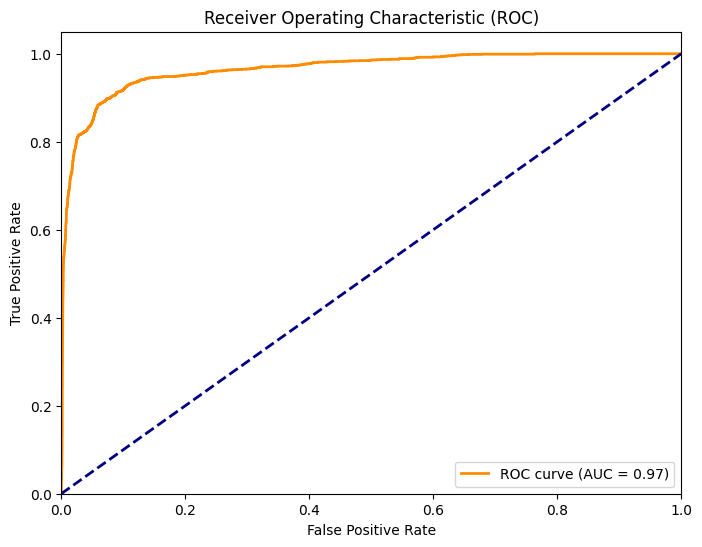

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and ROC AUC score
roc_auc = roc_auc_score(test_labels, reconstruction_errors)
fpr, tpr, _ = roc_curve(test_labels, reconstruction_errors)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

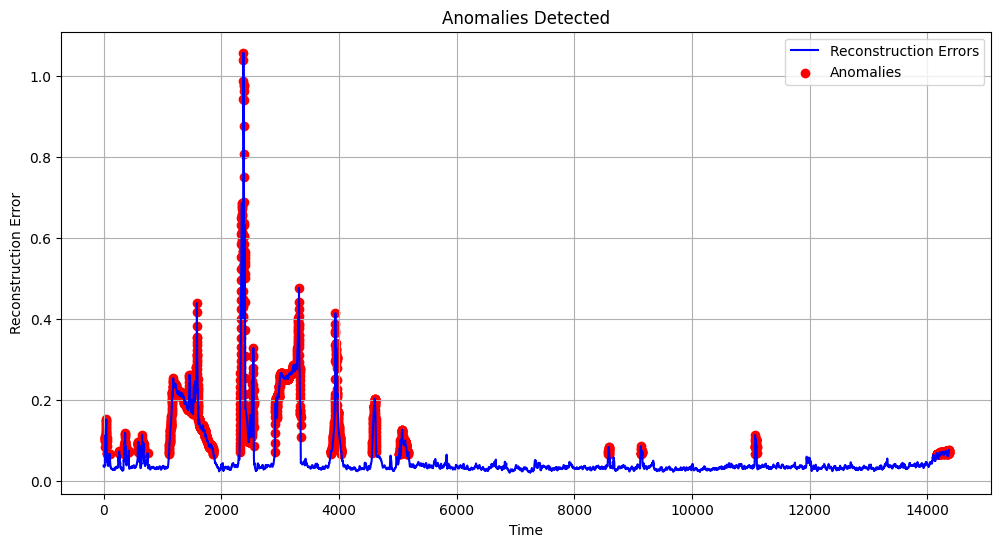

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have the `reconstruction_errors` and `predicted_anomalies` arrays

# Create a time axis for the x-axis
time_axis = range(len(reconstruction_errors))

# Plot the reconstruction errors
plt.figure(figsize=(12, 6))
plt.plot(time_axis, reconstruction_errors, label='Reconstruction Errors', color='b')

# Highlight anomalies in red
anomalies_x = [i for i, is_anomaly in enumerate(predicted_anomalies) if is_anomaly]
anomalies_y = [reconstruction_errors[i] for i in anomalies_x]
plt.scatter(anomalies_x, anomalies_y, marker='o', color='r', label='Anomalies')

plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.title('Anomalies Detected')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a3929e90c5403999526d72837138a8625fcf61c76e9a7b3def48c86abc42a184
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


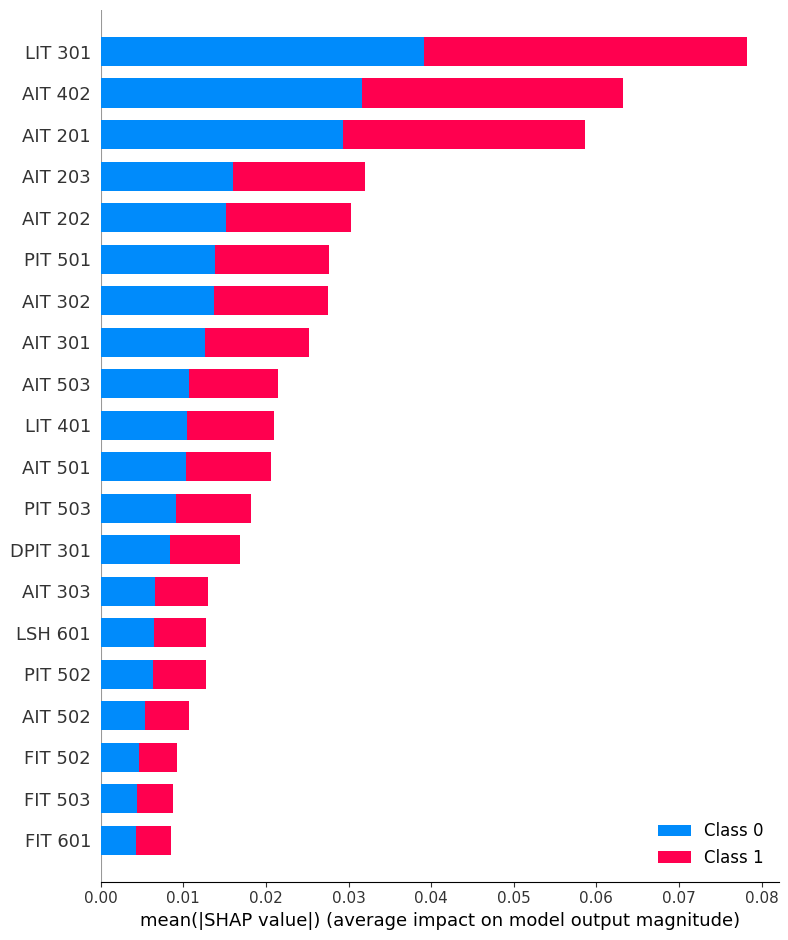

In [ ]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(forest)

# Calculate SHAP values for a subset of your data (for performance reasons)
shap_values = explainer.shap_values(X.sample(100))

# Plot the SHAP values
shap.summary_plot(shap_values, X.sample(100))


### **ACTIVE LEARNING**

In [ ]:
# Active learning part
threshold_margin = 0.05 * threshold
lower_bound = threshold - threshold_margin
upper_bound = threshold + threshold_margin

active_learning_candidates = np.where(
    (reconstruction_errors >= lower_bound) & (reconstruction_errors <= upper_bound)
)[0]

# Placeholder for collecting feedback
feedback = {}  # Dictionary with indices as keys and feedback as values

# Set the limit for the number of labeled instances
max_labeled_instances = 5  # Change this to your desired limit

def label_instance(index, label):
    feedback[index] = label
    remaining_candidates.remove(index)
    print(f"Instance {index} labeled as '{label}' ({len(feedback)}/{max_labeled_instances}).")
    if len(feedback) < max_labeled_instances and remaining_candidates:
        label_next_instance(remaining_candidates[0])
    else:
        print("Reached the maximum limit for labeled instances.")

def label_next_instance(index):
    instance = subset_df.iloc[index]
    print(f"Instance {index} ({len(feedback) + 1}/{max_labeled_instances} labeled):\n")
    print(instance)  # Display the instance details for user reference
    label = input("Is this instance an anomaly? (y/n): ").strip().lower()

    if label == 'y' or label == 'n':
        label_instance(index, label)
    else:
        print("Invalid input. Please enter 'y' or 'n'.")
        label_next_instance(index)

remaining_candidates = list(active_learning_candidates)

# Start the labeling process
if remaining_candidates:
    label_next_instance(remaining_candidates[0])
else:
    print("No active learning candidates found.")

# Update the dataset with the received feedback
for index in feedback:
    subset_df.loc[index, 'Normal/Attack'] = feedback[index]

# Retrain the model with the updated dataset

# Assuming X_train and X_valid are already preprocessed and ready for training
history = lstm_autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid, X_valid),
    callbacks=[early_stopping]
)

# Print evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_matrix)

Instance 23 (1/5 labeled):

FIT 101         -0.463164
LIT 101         -0.977246
MV 101          -0.417491
P1_STATE        -0.212852
P101 Status      1.368395
                   ...   
P601 Status     -0.127416
P602 Status      0.000000
P603 Status      0.000000
Normal/Attack    0.000000
weak_label       1.000000
Name: 2019-07-20 16:34:37, Length: 79, dtype: float64
Is this instance an anomaly? (y/n): y
Instance 23 labeled as 'y' (1/5).
Instance 54 (2/5 labeled):

FIT 101         -0.463164
LIT 101         -0.833639
MV 101          -0.417491
P1_STATE        -0.212852
P101 Status      1.368395
                   ...   
P601 Status     -0.127416
P602 Status      0.000000
P603 Status      0.000000
Normal/Attack    0.000000
weak_label       1.000000
Name: 2019-07-20 16:34:06, Length: 79, dtype: float64
Is this instance an anomaly? (y/n): y
Instance 54 labeled as 'y' (2/5).
Instance 55 (3/5 labeled):

FIT 101         -0.463164
LIT 101         -0.830767
MV 101          -0.417491
P1_STATE      

**HAI Security Dataset**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional, RepeatVector
from tensorflow.keras.regularizers import L1L2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [ ]:
# Load the dataset
#HAI Dataset
df = pd.read_csv('/content/drive/MyDrive/hai-23.05/hai-test2.csv')

In [ ]:
print(df.columns)
print(df.shape)

Index(['timestamp', 'P1_FCV01D', 'P1_FCV01Z', 'P1_FCV02D', 'P1_FCV02Z',
       'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT02', 'P1_FT02Z',
       'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z', 'P1_LIT01',
       'P1_PCV01D', 'P1_PCV01Z', 'P1_PCV02D', 'P1_PCV02Z', 'P1_PIT01',
       'P1_PIT01_HH', 'P1_PIT02', 'P1_PP01AD', 'P1_PP01AR', 'P1_PP01BD',
       'P1_PP01BR', 'P1_PP02D', 'P1_PP02R', 'P1_PP04', 'P1_PP04D', 'P1_PP04SP',
       'P1_SOL01D', 'P1_SOL03D', 'P1_STSP', 'P1_TIT01', 'P1_TIT02', 'P1_TIT03',
       'P2_24Vdc', 'P2_ATSW_Lamp', 'P2_AutoGO', 'P2_AutoSD', 'P2_Emerg',
       'P2_MASW', 'P2_MASW_Lamp', 'P2_ManualGO', 'P2_ManualSD', 'P2_OnOff',
       'P2_RTR', 'P2_SCO', 'P2_SCST', 'P2_SIT01', 'P2_TripEx', 'P2_VIBTR01',
       'P2_VIBTR02', 'P2_VIBTR03', 'P2_VIBTR04', 'P2_VT01', 'P2_VTR01',
       'P2_VTR02', 'P2_VTR03', 'P2_VTR04', 'P3_FIT01', 'P3_LCP01D',
       'P3_LCV01D', 'P3_LH01', 'P3_LIT01', 'P3_LL01', 'P3_PIT01', 'P4_HT_FD',
       'P4_HT_PO', 'P4_HT_PS', 'P

In [ ]:
# Assuming df is your DataFrame and it has a 'timestamp' column
df['timestamp'] = pd.to_datetime(df['timestamp'])

# List of attack periods
attack_periods = [
    ("2022-08-17 01:27:06", "2022-08-17 01:29:18"),
    ("2022-08-17 03:37:02", "2022-08-17 03:39:13"),
    ("2022-08-17 04:21:03", "2022-08-17 04:22:11"),
    ("2022-08-17 05:46:02", "2022-08-17 05:48:04"),
    ("2022-08-17 06:21:05", "2022-08-17 06:22:30"),
    ("2022-08-17 08:36:01", "2022-08-17 08:39:17"),
    ("2022-08-17 09:42:04", "2022-08-17 09:52:18"),
    ("2022-08-17 10:36:02", "2022-08-17 10:38:15"),
    ("2022-08-17 11:35:05", "2022-08-17 11:36:30"),
    ("2022-08-17 12:25:05", "2022-08-17 12:26:33"),
    ("2022-08-17 13:47:05", "2022-08-17 13:50:29"),
    ("2022-08-17 14:25:04", "2022-08-17 14:27:11"),
    ("2022-08-17 15:13:01", "2022-08-17 15:22:00"),
    ("2022-08-17 17:34:04", "2022-08-17 17:35:05"),
    ("2022-08-17 18:16:04", "2022-08-17 18:18:31"),
    ("2022-08-17 19:40:03", "2022-08-17 19:41:38"),
    ("2022-08-17 20:12:03", "2022-08-17 20:20:28"),
    ("2022-08-17 22:41:01", "2022-08-17 22:44:35"),
    ("2022-08-17 23:38:04", "2022-08-17 23:40:15"),
    ("2022-08-18 13:48:03", "2022-08-18 13:50:14"),
    ("2022-08-18 14:58:52", "2022-08-18 15:00:14"),
    ("2022-08-18 16:20:20", "2022-08-18 16:23:51"),
    ("2022-08-18 17:38:10", "2022-08-18 17:39:29"),
    ("2022-08-18 18:45:06", "2022-08-18 18:46:53"),
    ("2022-08-18 19:21:01", "2022-08-18 19:22:01"),
    ("2022-08-18 20:32:09", "2022-08-18 20:34:07"),
    ("2022-08-18 21:41:02", "2022-08-18 21:43:14"),
    ("2022-08-18 23:15:01", "2022-08-18 23:17:36"),
    ("2022-08-19 01:23:04", "2022-08-19 01:24:59"),
    ("2022-08-19 02:43:01", "2022-08-19 02:45:35"),
    ("2022-08-19 04:34:01", "2022-08-19 04:35:36"),
    ("2022-08-19 05:14:02", "2022-08-19 05:16:35"),
    ("2022-08-19 06:46:01", "2022-08-19 07:20:12"),
    ("2022-08-19 08:24:01", "2022-08-19 08:32:50"),
    ("2022-08-19 09:27:33", "2022-08-19 09:28:59"),
    ("2022-08-19 10:34:00", "2022-08-19 10:35:59"),
    ("2022-08-19 14:18:00", "2022-08-19 14:21:09"),
    ("2022-08-19 14:51:00", "2022-08-19 14:53:02")
]

# Convert attack periods to datetime and create a mask
attack_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in attack_periods]
mask = np.zeros(len(df), dtype=bool)
for start, end in attack_periods:
    mask |= ((df['timestamp'] >= start - pd.Timedelta(minutes=5)) & (df['timestamp'] <= end + pd.Timedelta(minutes=5)))

# Filter the DataFrame
df_subset = df[mask]
df=df_subset

# Convert attack periods to datetime
attack_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in attack_periods]

# Initialize a new column for attack labels
df['attack'] = 0

# Label the attacks
for start, end in attack_periods:
    df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'attack'] = 1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
print(df.columns)
print(df.shape)

Index(['timestamp', 'P1_FCV01D', 'P1_FCV01Z', 'P1_FCV02D', 'P1_FCV02Z',
       'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT02', 'P1_FT02Z',
       'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z', 'P1_LIT01',
       'P1_PCV01D', 'P1_PCV01Z', 'P1_PCV02D', 'P1_PCV02Z', 'P1_PIT01',
       'P1_PIT01_HH', 'P1_PIT02', 'P1_PP01AD', 'P1_PP01AR', 'P1_PP01BD',
       'P1_PP01BR', 'P1_PP02D', 'P1_PP02R', 'P1_PP04', 'P1_PP04D', 'P1_PP04SP',
       'P1_SOL01D', 'P1_SOL03D', 'P1_STSP', 'P1_TIT01', 'P1_TIT02', 'P1_TIT03',
       'P2_24Vdc', 'P2_ATSW_Lamp', 'P2_AutoGO', 'P2_AutoSD', 'P2_Emerg',
       'P2_MASW', 'P2_MASW_Lamp', 'P2_ManualGO', 'P2_ManualSD', 'P2_OnOff',
       'P2_RTR', 'P2_SCO', 'P2_SCST', 'P2_SIT01', 'P2_TripEx', 'P2_VIBTR01',
       'P2_VIBTR02', 'P2_VIBTR03', 'P2_VIBTR04', 'P2_VT01', 'P2_VTR01',
       'P2_VTR02', 'P2_VTR03', 'P2_VTR04', 'P3_FIT01', 'P3_LCP01D',
       'P3_LCV01D', 'P3_LH01', 'P3_LIT01', 'P3_LL01', 'P3_PIT01', 'P4_HT_FD',
       'P4_HT_PO', 'P4_HT_PS', 'P

In [ ]:
from sklearn.preprocessing import StandardScaler

# Separate the Attack column
attack_series = df.pop('attack')

# Normalize the numeric columns, exclude the Attack column
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'attack']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Add the Attack column back to the dataframe
df['attack'] = attack_series

# Fill missing values with zeros
df.fillna(0, inplace=True)


In [ ]:
df = df.set_index('timestamp')

In [ ]:
df = df.astype(np.float32)

In [ ]:
# Improve weak labeling function
def weak_label(row, threshold_multiplier=2):
    thresholds = {
    'P1_PIT01': (-0.0067, 0.843),
    'P1_PCV01D': (-0.0274, 0.712),
    'P1_FT03': (0.0043, 0.993),
    'P1_LIT01': (-0.0215, 0.872),
    'P1_FCV03D': (0.0028, 0.969),
    'P1_LCV01D': (-0.0177, 0.716),
    'P1_PP04': (0.0158, 0.998),
    'P1_FCV01D': (-0.0146, 0.985),
    'P1_TIT01': (-0.0193, 0.994),
    'P1_TIT03': (-0.0012, 1.002),
    }
    for sensor, (mean, std) in thresholds.items():
        if row[sensor] > (mean + threshold_multiplier * std) or row[sensor] < (mean - threshold_multiplier * std):
            return 1
    return row['attack']

df['weak_label'] = df.apply(weak_label, axis=1)


In [ ]:
# RandomForest for feature selection
X = df.drop(columns=['attack'], axis=1)
y = df['attack']
forest = RandomForestClassifier(n_estimators=150, random_state=80)
forest.fit(X, y)
importances = forest.feature_importances_
top_n = 20  # Select top 20 features 19 best
indices = np.argsort(importances)[-top_n:]
selected_features = X.columns[indices]

In [ ]:
# Data preprocessing using selected features
reduced_data = df[selected_features]
scaler = StandardScaler()
reduced_data = scaler.fit_transform(reduced_data)
normal_reduced_data = reduced_data[df['attack'] == 0]

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
# Function to create sequences
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)

# Parameters for sequence creation
timesteps = 40  # Length of each sequence
normal_sequences = create_sequences(normal_reduced_data, timesteps)

# Split normal data into training and validation sets
X_train, X_valid = train_test_split(normal_sequences, test_size=0.3, random_state=80)

# LSTM Autoencoder
n_features_reduced = top_n  # Number of features

def create_optimal_lstm_autoencoder():
    model = Sequential([
        LSTM(384, activation='tanh', input_shape=(timesteps, n_features_reduced), return_sequences=False),
        RepeatVector(timesteps),
        LSTM(384, activation='tanh', return_sequences=True),
        TimeDistributed(Dense(n_features_reduced))
    ])
    optimizer = RMSprop(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mae')
    return model

lstm_autoencoder = create_optimal_lstm_autoencoder()

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True
)

# Train the LSTM autoencoder
history = lstm_autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_valid, X_valid),
    callbacks=[early_stopping]
)

Epoch 1/50
249/249 [==============================] - 8s 21ms/step - loss: 0.3250 - val_loss: 0.1582
Epoch 2/50
249/249 [==============================] - 5s 18ms/step - loss: 0.1275 - val_loss: 0.1067
Epoch 3/50
249/249 [==============================] - 5s 18ms/step - loss: 0.1045 - val_loss: 0.0945
Epoch 4/50
249/249 [==============================] - 5s 18ms/step - loss: 0.0914 - val_loss: 0.0930
Epoch 5/50
249/249 [==============================] - 4s 18ms/step - loss: 0.0842 - val_loss: 0.0830
Epoch 6/50
249/249 [==============================] - 4s 18ms/step - loss: 0.0790 - val_loss: 0.0808
Epoch 7/50
249/249 [==============================] - 4s 18ms/step - loss: 0.0756 - val_loss: 0.0735
Epoch 8/50
249/249 [==============================] - 4s 18ms/step - loss: 0.0727 - val_loss: 0.0714
Epoch 9/50
249/249 [==============================] - 4s 18ms/step - loss: 0.0698 - val_loss: 0.0734
Epoch 10/50
249/249 [==============================] - 4s 18ms/step - loss: 0.0689 - val_lo

In [ ]:
# Preparing test data
test_data = df[selected_features]
test_data = scaler.transform(test_data)
test_sequences = create_sequences(test_data, timesteps)
test_labels = np.array([label for _ in range(timesteps) for label in df['attack']][:(len(test_sequences))])

# Predicting and calculating reconstruction error
test_predictions = lstm_autoencoder.predict(test_sequences)
reconstruction_errors = np.mean(np.abs(test_predictions - test_sequences), axis=(1,2))

# Determine a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 85)
predicted_anomalies = reconstruction_errors > threshold

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, predicted_anomalies)
precision = precision_score(test_labels, predicted_anomalies)
recall = recall_score(test_labels, predicted_anomalies)
f1 = f1_score(test_labels, predicted_anomalies)
conf_matrix = confusion_matrix(test_labels, predicted_anomalies)

# Print evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_matrix)

974/974 [==============================] - 4s 4ms/step
Accuracy:  0.8711292237589449
Precision:  0.9691978609625669
Recall:  0.5392121861240033
F1 Score:  0.6929194066371004
Confusion Matrix:
 [[22616   144]
 [ 3872  4531]]


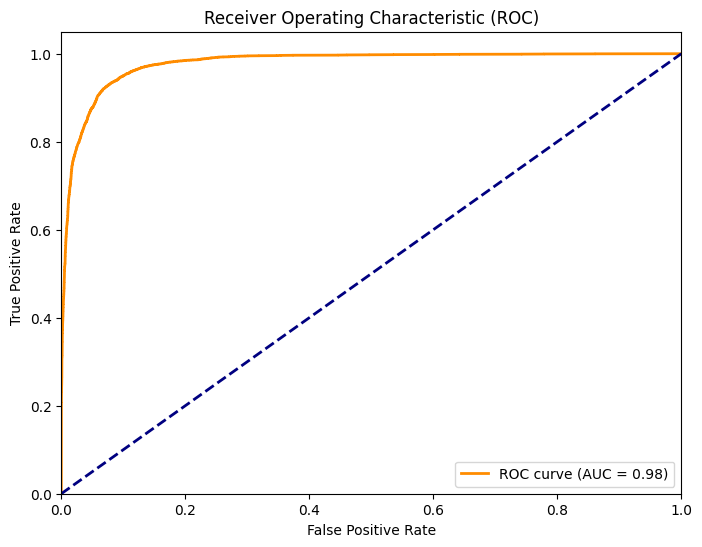

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and ROC AUC score
roc_auc = roc_auc_score(test_labels, reconstruction_errors)
fpr, tpr, _ = roc_curve(test_labels, reconstruction_errors)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

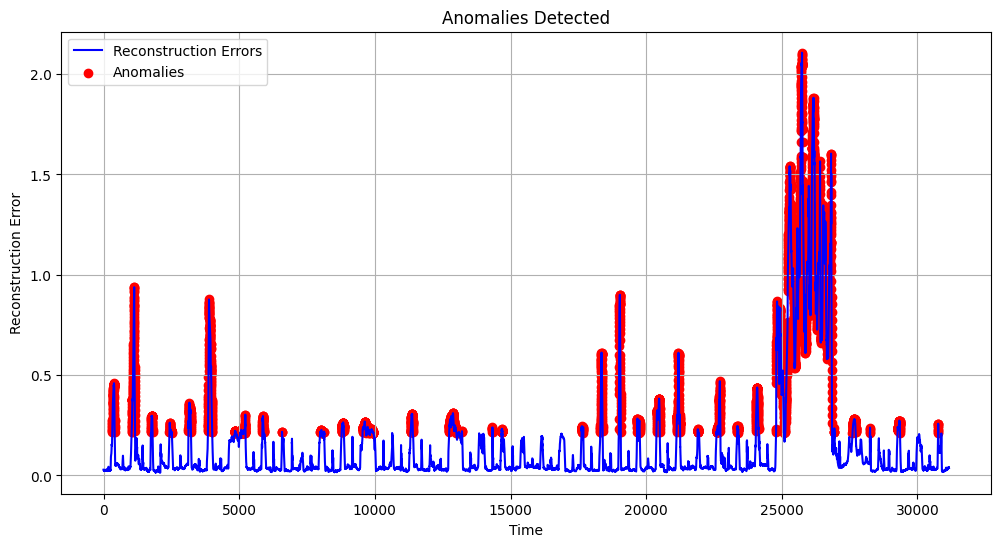

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have the `reconstruction_errors` and `predicted_anomalies` arrays

# Create a time axis for the x-axis
time_axis = range(len(reconstruction_errors))

# Plot the reconstruction errors
plt.figure(figsize=(12, 6))
plt.plot(time_axis, reconstruction_errors, label='Reconstruction Errors', color='b')

# Highlight anomalies in red
anomalies_x = [i for i, is_anomaly in enumerate(predicted_anomalies) if is_anomaly]
anomalies_y = [reconstruction_errors[i] for i in anomalies_x]
plt.scatter(anomalies_x, anomalies_y, marker='o', color='r', label='Anomalies')

plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.title('Anomalies Detected')
plt.legend()
plt.grid(True)
plt.show()

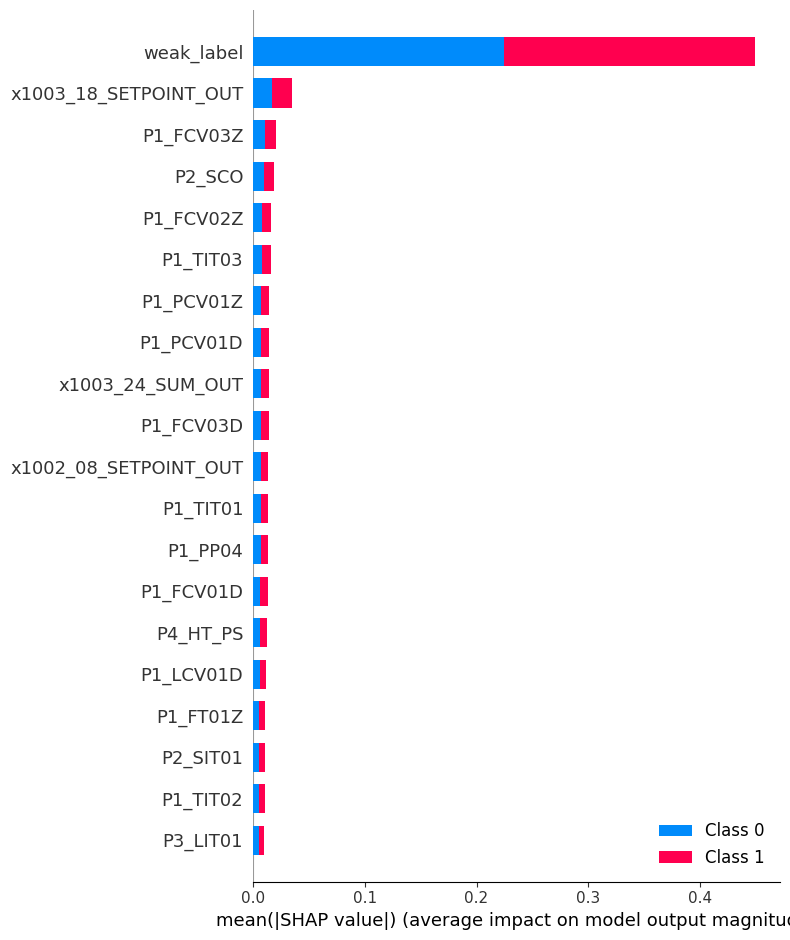

In [ ]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(forest)

# Calculate SHAP values for a subset of your data (for performance reasons)
shap_values = explainer.shap_values(X.sample(100))

# Plot the SHAP values
shap.summary_plot(shap_values, X.sample(100))


In [ ]:
# Active learning part
threshold_margin = 0.05 * threshold
lower_bound = threshold - threshold_margin
upper_bound = threshold + threshold_margin

active_learning_candidates = np.where(
    (reconstruction_errors >= lower_bound) & (reconstruction_errors <= upper_bound)
)[0]

# Placeholder for collecting feedback
feedback = {}  # Dictionary with indices as keys and feedback as values

# Set the limit for the number of labeled instances
max_labeled_instances = 5  # Change this to your desired limit

def label_instance(index, label):
    feedback[index] = label
    remaining_candidates.remove(index)
    print(f"Instance {index} labeled as '{label}' ({len(feedback)}/{max_labeled_instances}).")
    if len(feedback) < max_labeled_instances and remaining_candidates:
        label_next_instance(remaining_candidates[0])
    else:
        print("Reached the maximum limit for labeled instances.")

def label_next_instance(index):
    instance = df.iloc[index]
    print(f"Instance {index} ({len(feedback) + 1}/{max_labeled_instances} labeled):\n")
    print(instance)  # Display the instance details for user reference
    label = input("Is this instance an anomaly? (y/n): ").strip().lower()

    if label == 'y' or label == 'n':
        label_instance(index, label)
    else:
        print("Invalid input. Please enter 'y' or 'n'.")
        label_next_instance(index)

remaining_candidates = list(active_learning_candidates)

# Start the labeling process
if remaining_candidates:
    label_next_instance(remaining_candidates[0])
else:
    print("No active learning candidates found.")

# Update the dataset with the received feedback
for index in feedback:
    df.loc[index, 'attack'] = feedback[index]

# Retrain the model with the updated dataset

# Assuming X_train and X_valid are already preprocessed and ready for training
history = lstm_autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid, X_valid),
    callbacks=[early_stopping]
)

# Print evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_matrix)

Instance 319 (1/5 labeled):

P1_FCV01D               -0.443554
P1_FCV01Z               -0.414579
P1_FCV02D               -0.854138
P1_FCV02Z               -0.860371
P1_FCV03D                0.054350
                           ...   
x1003_10_SETPOINT_OUT   -0.137045
x1003_18_SETPOINT_OUT   -0.948314
x1003_24_SUM_OUT        -1.085299
attack                   1.000000
weak_label               1.000000
Name: 2022-08-17 01:27:25, Length: 88, dtype: float64
Is this instance an anomaly? (y/n): y
Instance 319 labeled as 'y' (1/5).
Instance 320 (2/5 labeled):

P1_FCV01D               -0.449917
P1_FCV01Z               -0.437378
P1_FCV02D               -0.854138
P1_FCV02Z               -0.860371
P1_FCV03D                0.038172
                           ...   
x1003_10_SETPOINT_OUT   -0.141548
x1003_18_SETPOINT_OUT   -0.948314
x1003_24_SUM_OUT        -1.096964
attack                   1.000000
weak_label               1.000000
Name: 2022-08-17 01:27:26, Length: 88, dtype: float64
Is this insta